In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


from configurations import load_data, make_data_paths, save_fig, create_fig, set_font_sizes, apply_general_styles, make_params_dict
from configurations.plot_config import FONTSIZES
# from sam.small_models import InductionHeadAttention, warm_initialization, interpolation_initialization
from sam.small_models import noisy_initialization
from sam.dataset import get_sample_permut, get_dataloader
from sam.evaluation import evaluate_model

apply_general_styles()

# Test New rescaled models

In [28]:
Ls = [8, 16, 32, 64, 128, 256, 512, 1024,2048]
CVS = [1.0,1.01,1.1]

results = {}

for cV in CVS:
    results[cV] = {
        'loss': [],
        'accuracy': [],
        'target_mass': []
    }
    for L in Ls:
        config = {
            'vocab_size': L,
            'seq_len': L,
            'dropout': 0.0,
            'alpha' : 0.0,
            'beta_1' : 1.0,
            'beta_2' : 1.0,
            'beta_out' : 1.0,
            'sigma' : 0.2,
            'cV' : cV,
            'dataset_size' : 1000,
            'train_fraction': 0.99,
            'batch_size' : 1,
        }

        train_list = ['beta_1','beta_2','beta_out','WQ1.weight', 'WK1.weight','WV1.weight']

        model , device = noisy_initialization(config, train_list=train_list)
        loader , _  = get_dataloader(config)
        CE_loss = torch.nn.CrossEntropyLoss()
        val_loss , val_accuracy , target_mass = evaluate_model(model, loader, device, CE_loss)
        results[cV]['loss'].append(val_loss)
        results[cV]['accuracy'].append(val_accuracy)
        results[cV]['target_mass'].append(target_mass)


# print(f"Validation Loss: {val_loss:.4f}")
# print(f"Validation Accuracy: {val_accuracy:.4f}")
# print(f"Validation Accuracy (Sample-wise): {target_mass:.4f}")


Figure saved on /u/c/cerazova/SAM/plots/2026-02 as simplified_task_results.png


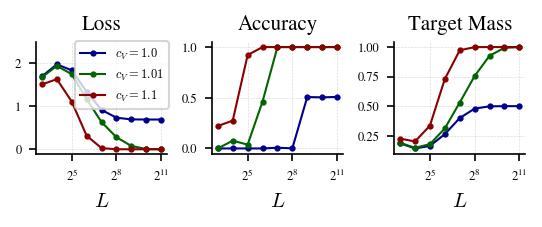

In [45]:
# Settings
colors = ['darkblue', 'darkgreen', 'darkred', 'red', 'purple', 'brown']
set_font_sizes(conf='tight')
# Plot

fig , axes = create_fig(ncols=3, nrows=1,h=0.4)

for i , key in enumerate(results[cV].keys()):
    ax = axes[i]
    ax.set_xlabel(r'$L$')
    title = key.replace('_', ' ').title()
    ax.set_title(rf'{title}')
    ax.grid(ls='--', alpha=0.5,lw=0.3)
    for j , cV in enumerate(CVS):
        ax.plot(Ls, results[cV][key], marker='.',color=colors[j], label=rf'$c_V={cV}$',lw=1.0,markersize=4)

ax.set_xscale('log', base=2)
axes[0].set_ylim(top=2.5)
axes[0].legend(frameon=True,loc=(0.3,0.4),fontsize=FONTSIZES['xs'])

save_fig(fig,'simplified_task_results',date=True)

In [11]:
batch = next(iter(loader))
input = batch['input'].to(device)
target = batch['target'].to(device)
with torch.no_grad():
    output = model.full_output(input)
    # logits = model(input)  # (batch_size, vocab_size)

# probs = torch.softmax(logits, dim=-1)  # (batch_size, vocab_size)
# mass_at_target = probs[torch.arange(probs.size(0)), target] # (batch_size) - probability mass assigned to the correct target token
# print('Mass at target token:\n', mass_at_target.cpu().numpy())


print('Input:\n', input.cpu().numpy())
print('Target:\n', target.cpu().numpy())
# print(output.keys())

# sample from output['probs']
# print(probs[0].max())

Input:
 [[49 93 17 72 58 33 68 80 27  0 60 75 69 12 91  6 28 39 23  8 97 77 96  3
  10 63 45 82 32 55 74 14 41 43 35 87 15  9 90 86 88 37 42 29 48 92 16 83
  20 44 11 64 62 84 67 22 24 71 52 40 13 19 59 38 57  4 56 66 30 51 94 73
   2 26 78 79 61  1 53 65 47 89 95  5 54 50 18 98 34 25 70 81 36 46 85  7
  31 99 76 60]]
Target:
 [75]


Predicted token: 21
Mass at target token: 0.0000
max prob: 0.9953   


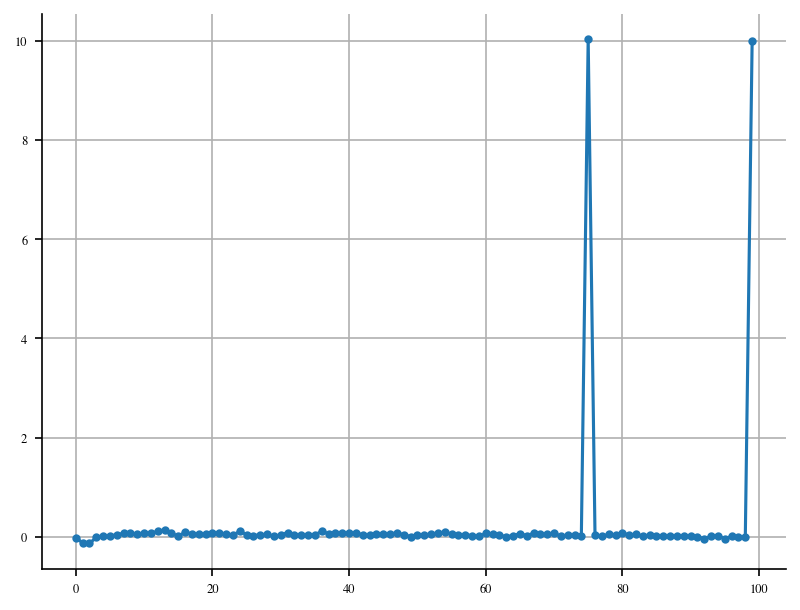

In [9]:
prediction = np.random.choice(config['vocab_size'], p=output['probs'])
print('Predicted token:', prediction)
plt.plot(output['S2'],marker='.')
# plt.yscale('log')
plt.grid()
# plt.xlim(30, 40)
mass_at_target = output['probs'][target[0].cpu().item()]
print(f"Mass at target token: {mass_at_target:.4f}")
print(f'max prob: {output["probs"].max():.4f}   ')

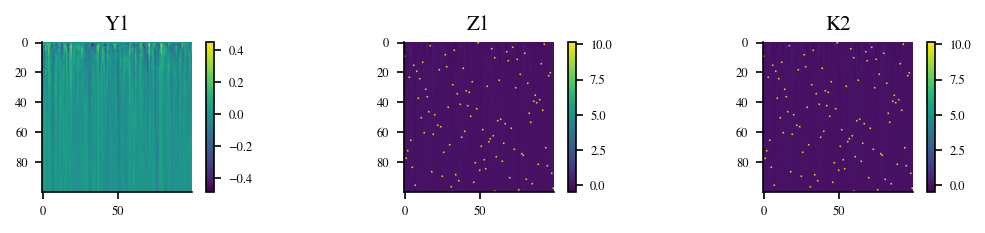

In [13]:
# keys = output.keys() - {'logits','q2','S2','A2','Y2','logits'}
# keys = ['E','P','Q1','K1','S1','V1','A1']
keys = ['Y1','Z1','K2']
# keys = ['q2','S2','A2','Y2','logits']
ncols = len(keys)
fig , axes = create_fig(nrows=1,ncols=ncols,size='double',h=0.2,sharex=False)

for i , k in enumerate(keys):
    ax = axes[i]
    ax.set_title(k)
    # ax.plot(output[k],marker='.')
    im = ax.imshow(output[k],cmap='viridis')
    
    fig.colorbar(im, ax=ax, orientation='vertical')


# Optimal from Noisy Start

In [63]:
# Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
lr = 0.05 # Learning rate
cV = 1.1 # Coefficient for WV1
opt = 'SGD' # Optimizer choice = 'SGD' or 'adam' or 'SAM'
rho = 0.0
gamma = 0.0 # Weight decay for sgd
p_error = 0.0 # Probability of random token replacement in the input sequence (data

fix_names = ['vocab_size','seq_len','lr']
alphas = [0.0,0.2,0.4,0.6,0.8,1.0][:]  # Interpolation parameter for initialization (0: planted, 1: random)
keys = ['train_loss', 'val_loss', 'val_accuracy', 'target_mass']

results = {key: {alpha: [] for alpha in alphas} for key in keys}




for alpha in alphas:       
    var_names = ['alpha','cV','opt','rho','gamma','p_error'][:2]
    params = make_params_dict(fix_names, var_names)
    summary = load_data('summary',experiment_name='small_induction_head', params=params,show=False)
    for key in keys:
        results[key][alpha] = summary[key]
      

results['step'] = summary['step']

for key in keys:
    print(f'{key}: {results[key][alpha].shape}')



train_loss: (50,)
val_loss: (50,)
val_accuracy: (50,)
target_mass: (50,)


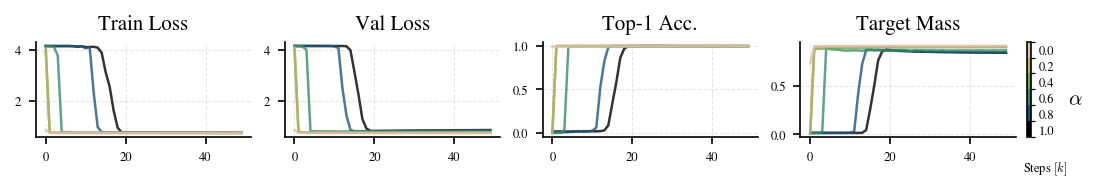

In [65]:
# Settings
ncols = len(keys)
cmap = 'gist_earth'
colors = plt.get_cmap(cmap)(np.linspace(0.0,0.9,len(alphas)))
set_font_sizes(conf='tight')
titles = ['Train Loss', 'Val Loss', 'Top-1 Acc.', 'Target Mass']

# Plotting
fig ,  axes = create_fig(ncols=ncols,size='double',h=0.15)

for i , (ax , key) in enumerate(zip(axes, keys)):
    for j , alpha in enumerate(alphas[::-1]):
        ax.plot(results['step']/1000, results[key][alpha],lw=1.2,alpha=0.8,color=colors[j],label=[fr'${alpha}$' if (i == ncols-1) else None])
    ax.set_title(titles[i])
    ax.grid(ls='--',alpha=0.2,c='gray',lw=0.5)
    # xticks = ax.get_xticks()
    # xticks_labels = [rf'${int(x)}$ k' for x in xticks]
    # ax.set_xticks(xticks, labels=xticks_labels)
    
    # if 'loss' in key:
    #     ax.set_ylim(0,6)
    #     # ax.axhline(np.log(vocab_size), ls='--', c='purple', lw=0.5)
    # if 'acc' in key:
    #     ax.set_ylim(0,1)
    
# ax.set_xscale('log')
# ax.set_xlim(0,20)
# Create discrete colormap and colorbar with discrete colors
cmap = ListedColormap(colors)
bounds = np.arange(len(alphas) + 1)
norm = BoundaryNorm(bounds, cmap.N)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap,norm=norm),
    ax=ax, orientation='vertical',pad=0.05)

cbar.set_label(r'$\alpha$', rotation=0, labelpad=10)
# Ticks and labels
cbar.set_ticks(ticks=(np.arange(len(alphas)) + 0.5), labels= alphas[::-1])
cbar.ax.tick_params(length=0)  # Optional: remove tick lines for clarity
# ax.set_xscale('log')
# ax.set_xlim(0,25)
# axes[0].set_ylim(0,6)
# axes[1].set_ylim(0,6)
fig.text(0.96, 0.01, r'Steps $[k]$', ha='center', va='center', fontsize=FONTSIZES['xs'])
params = make_params_dict(fix_names)
# save_fig(fig, 'linear_attention_learning',params=params,date=True)


# Optimal Model

In [16]:
from sam.small_models import InductionHeadAttention
from sam.dataset import get_sample_permut

In [75]:
# Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
lr = 0.05 # Learning rate
alpha = 0.2
cV = 1.1    
opt = 'SGD'
rho = 0.0
gamma = 0.0 # Weight decay for sgd
p_error = 0.0 # Probability of random token replacement in the input sequence (data

states = ['init','fin']

fix_names = ['vocab_size','seq_len','lr']
var_names = ['alpha','cV','opt','rho','gamma','p_error'][:2]
params = make_params_dict(fix_names, var_names)

model = InductionHeadAttention(vocab_size=vocab_size, seq_len=seq_len)
models = {}
for state in states:
    file_path , _, _ = make_data_paths(f'model_{state}', experiment_name= 'small_induction_head', params=params,ext='pt',base_dir='../data')     
    models[state] = torch.load(file_path)

for key in models[state].keys():
    print(key, models[state][key].shape)

for state in states:
    text = ''
    for key in models[state].keys():
        if 'beta' in key:
            text += f'{key}: {models[state][key].cpu().numpy()}'
    print(f'{state}:\n{text}')

beta_1 torch.Size([])
beta_2 torch.Size([])
beta_out torch.Size([])
embedding.weight torch.Size([64, 64])
positions.weight torch.Size([64, 64])
WQ1.weight torch.Size([64, 64])
WK1.weight torch.Size([64, 64])
WV1.weight torch.Size([64, 64])
WQ2.weight torch.Size([64, 64])
WK2.weight torch.Size([64, 64])
init:
beta_1: 1.0beta_2: 1.0beta_out: 1.0
fin:
beta_1: 1.0beta_2: 1.0beta_out: 1.0


/tmp/ipykernel_3202769/1014747279.py:46: MatplotlibDeprecationWarning: Since Matplotlib 3.10 indicate_inset_[zoom] returns a single InsetIndicator artist with a rectangle property and a connectors property.  From 3.12 it will no longer be possible to unpack the return value into two elements.
  box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)


Figure saved on /u/c/cerazova/SAM/plots/2026-02 as init_fin_matrices_alpha0.2_lr0.05_seq_len64_vocab_size64.png


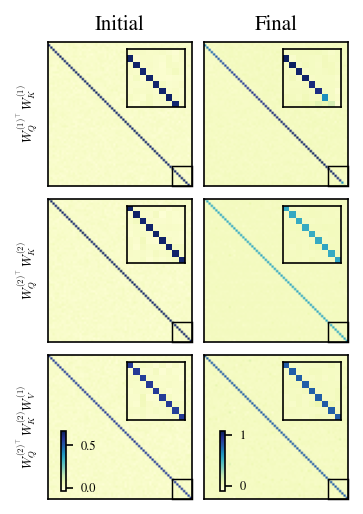

In [76]:
set_font_sizes(conf='tight')
cmap = 'YlGnBu'
titles = [r'$W_Q^{(1)^\top} W_K^{(1)}$',r'$W_Q^{(2)^\top} W_K^{(2)}$',r'$W_Q^{(2)^\top} W_K^{(2)} W_V^{(1)}$']
ncols = 2
nrows = 3
V = vocab_size
x = np.arange(V)
# Create figure
fig , axes = create_fig(ncols=ncols,nrows=nrows,size='double',w=0.32,h=0.46,sharex=False)

for i , state in enumerate(states):
    WQ1 = models[state]['WQ1.weight'].cpu().numpy()
    WK1 = models[state]['WK1.weight'].cpu().numpy()
    WQ2 = models[state]['WQ2.weight'].cpu().numpy()
    WK2 = models[state]['WK2.weight'].cpu().numpy()
    WV1 = models[state]['WV1.weight'].cpu().numpy()
    matrices = [WQ1.T@WK1, WQ2.T@WK2, WQ2.T@WK2@WV1]
    mx = -1e9
    mn = 1e9
    for M in matrices:
        mx = max(mx, M.max())
        mn = min(mn, M.min())

    for j , lb in enumerate(titles):
        ax = axes[j,i]
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.spines[['bottom','left','top','right']].set_visible(True)
        if j == 0: ax.set_title([r'Initial', r'Final'][i])
        if i == 0: ax.set_ylabel(titles[j],fontsize=FONTSIZES['xs']) 
        M = matrices[j]
        # mx = M.max()
        # ax.pcolormesh(x,x[::-1],M,cmap=cmap,vmax=mx*0.3,shading=None)
        im = ax.imshow(M,cmap=cmap,vmax=mx,vmin=mn)
        # Insert axis to show closer look at the top-left corner
        if True:
            axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4])  # [x0, y0, width, height]
            axins.spines[['bottom','left','top','right']].set_visible(True)
            # axins.pcolormesh(x,x[::-1],M,cmap=cmap,vmax=mx*0.3)
            axins.imshow(M,cmap=cmap,vmax=mx,vmin=mn)
            # axins.plot([0,V],[0,V],ls='--',c='red',lw=0.5)
            axins.set_xlim(V-9.5,V-0.5)
            axins.set_ylim(V-0.5,V-9.5)
            axins.set_xticks([])
            axins.set_yticks([])
            # ax.indicate_inset_zoom(axins, edgecolor='black', lw=0.5)
            box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)
            c1[0].set_visible(False)
            c1[1].set_visible(False)
            c1[2].set_visible(False)
            c1[3].set_visible(False)
            # ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)
            plt.setp([c1[:]], linestyle=":", lw=0.7)
            

# Add a floating colorbar on the center of the figure
cbar_ax = fig.add_axes([0.15, 0.03, 0.015, 0.12])  # [left, bottom, width, height]
cbar = fig.colorbar(axes[0,0].images[0], cax=cbar_ax)

cbar_ax = fig.add_axes([0.61, 0.03, 0.015, 0.12])  # [left, bottom, width, height]
cbar = fig.colorbar(axes[0,1].images[0], cax=cbar_ax)
# Set ticks color to white
# cbar.ax.tick_params(labelcolor='white')

# cbar.set_label('Value', rotation=270, labelpad=15)
# names = [*fix_names, '']
params = make_params_dict([*fix_names,'alpha'])
# params = make_params_dict
# params
save_fig(fig, 'init_fin_matrices',params=params,date=True)


In [30]:
l = 'init_fin_matrices_linear_attn_alpha1_lr0.05_seq_len64_vocab_size64.png'
len(l)

70

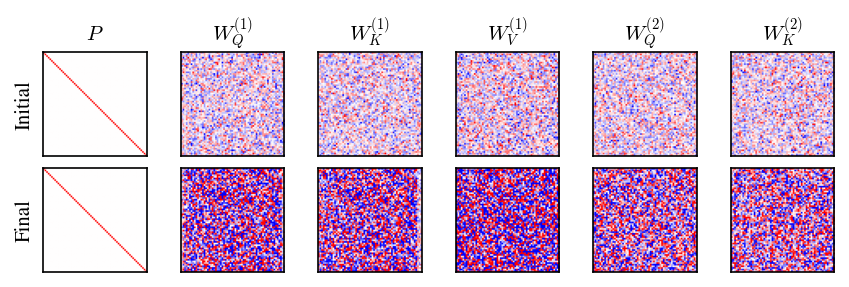

In [6]:
# Settings
keys = ['positions','WQ1','WK1','WV1','WQ2','WK2','WV2'][:-1]
titles = [r'$P$',r'$W_Q^{(1)}$',r'$W_K^{(1)}$',r'$W_V^{(1)}$',r'$W_Q^{(2)}$',r'$W_K^{(2)}$',r'$W_V^{(2)}$'][:-1]
ncols = len(keys)
# w_ratios = [ max(models['init'][f'{key}.weight'].shape) for key in keys]
# w_ratios = [1,3,3,1,1.5,1.5,1.5]
w_ratios = [1]*len(keys)
cmap = 'bwr'
# vlim = [0.05,0.05,0.05,0.05,0.05,0.05,0.05]
vlim = [0.1]*len(keys)
set_font_sizes(conf='tight')

# Create figure
fig , axes = create_fig(ncols=ncols,nrows=2,size='double',w=0.78,h=0.25,sharex=False,w_ratios=w_ratios)

for i, state in enumerate(states):
    for j , key in enumerate(keys):
        ax = axes[i,j]
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        # ax.set_axis_off()
        ax.spines[['bottom','left','top','right']].set_visible(True)
        if i == 0 : ax.set_title(titles[j])
        if j == 0: ax.set_ylabel(['Initial','Final'][i])
        variable = models[state][f'{key}.weight'].cpu().numpy()
        im = ax.imshow(variable,  cmap=cmap,vmin=-vlim[j],vmax=vlim[j])
        
        # ax.grid(ls='--',alpha=0.2,c='gray',lw=0.5)

# Add colorbar to the last column
# cbar = fig.colorbar(im, ax=axes[:,-1], orientation='vertical',pad=0.1)

names = ['vocab_size','seq_len','lr','alpha']
params = make_params_dict(names)
# save_fig(fig, 'params_init_fin_small',params=params,date=True)

In [7]:
state = models['fin']
model.load_state_dict(state)

input , target , _ = get_sample_permut(vocab_size,seq_len)
input = input.unsqueeze(0)
target = target.unsqueeze(0)
# print('Input:\n', input)
# print('Target:\n', target)

output = model.full_output(input)
print(input)
print(target)

tensor([[50,  4, 33, 15,  8, 43, 30,  7, 54,  9, 19, 12, 10, 49, 58, 40, 18, 35,
         47, 34, 57, 13, 44,  6, 36, 61,  1, 56, 46, 26, 17, 62, 22, 27, 51, 32,
         28,  5, 52, 21, 37, 25,  2, 31, 63, 29, 48, 14, 23, 60, 39, 45,  3, 11,
         20, 38, 59, 53,  0, 24, 42, 16, 41, 24]])
tensor([42])


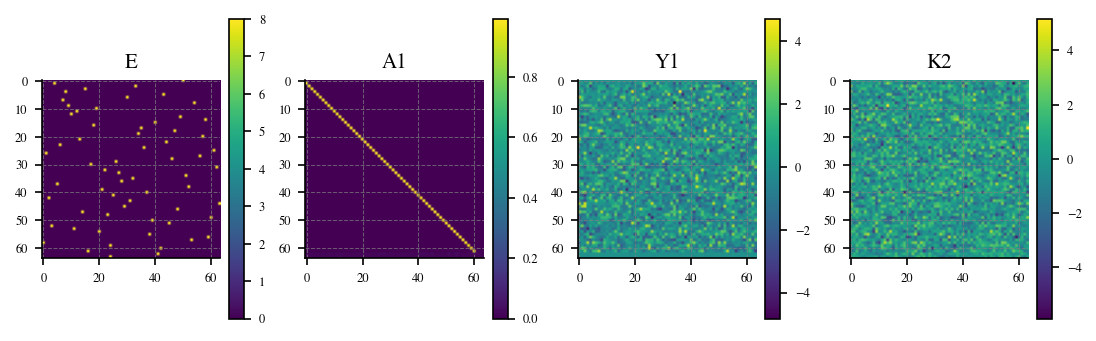

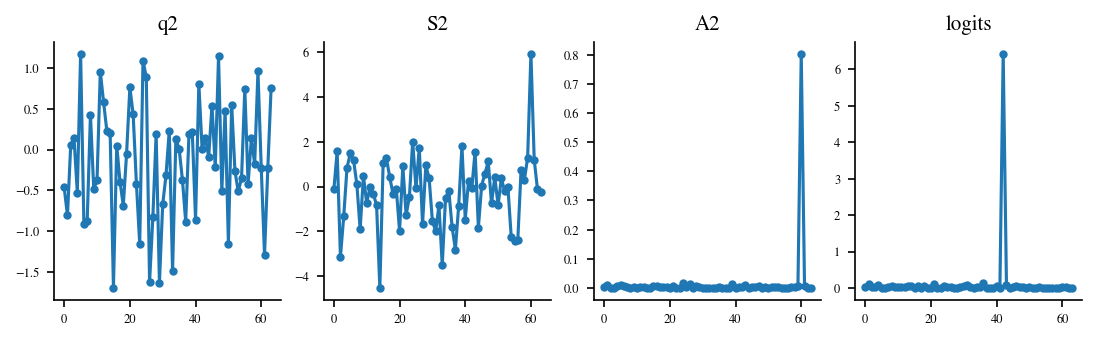

In [8]:
# keys = output.keys() - {'logits','q2','S2','A2','Y2','logits'}
keys = ['E','A1','Y1','K2']
# keys = ['Y1','Z1','K2']
# keys = ['q2','S2','A2','Y2','logits']
ncols = len(keys)
fig , axes = create_fig(nrows=1,ncols=ncols,size='double',h=0.3,sharex=False)

for i , k in enumerate(keys):
    ax = axes[i]
    ax.set_title(k)
    ax.grid(ls='--',alpha=0.7,c='gray',lw=0.5)
    # ax.plot(output[k],marker='.')
    im = ax.imshow(output[k],cmap='viridis')
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.show()

# keys = ['Y1','Z1','K2']
keys = ['q2','S2','A2','logits']
ncols = len(keys)
fig , axes = create_fig(nrows=1,ncols=ncols,size='double',h=0.3,sharex=False)

for i , k in enumerate(keys):
    ax = axes[i]
    ax.set_title(k)
    ax.plot(output[k],marker='.')

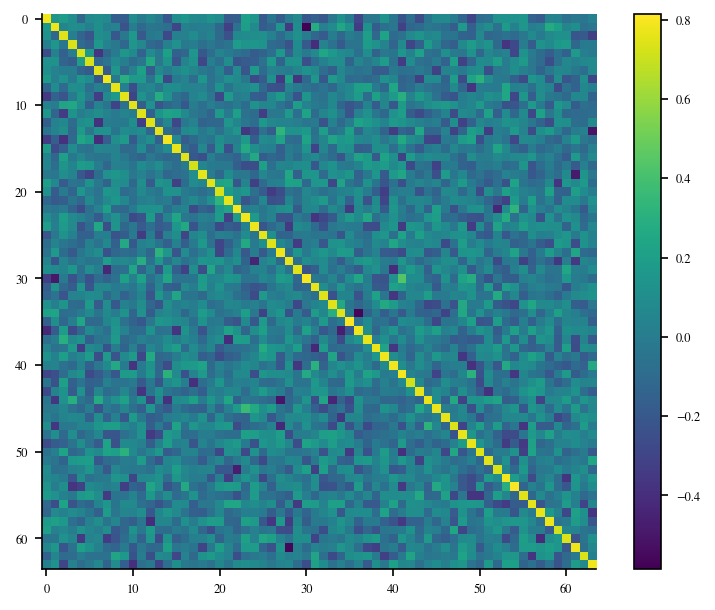

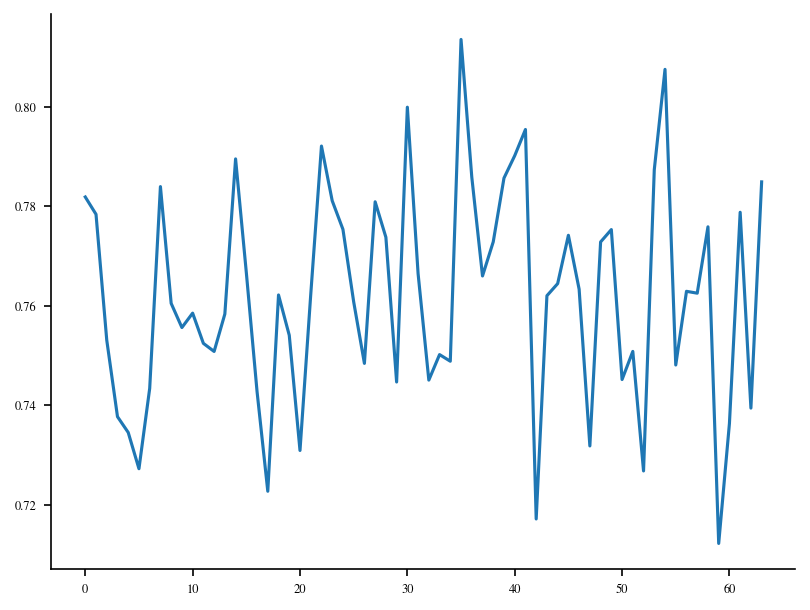

In [13]:
W1 = models['fin'][f'WQ2.weight'].cpu()
W2 = models['fin'][f'WK2.weight'].cpu()
W3 = models['fin'][f'WV1.weight'].cpu()


S = (W1.T@W2@W3)


plt.imshow(S)#[-10:,-10:])
plt.colorbar()
plt.show()

# mu = np.arange(1,A.shape[0])
# y = 1/(1+(mu-1)*math.exp(-math.sqrt(seq_len)))
# plt.plot(mu,np.diag(S,k=-1),marker='.')
# plt.plot(mu,y)
# plt.ylim(0.9,1)

# # k=1/np.sqrt(seq_len)

x = np.arange(0,S.shape[0])
# # y = np.exp(-)
plt.plot(x,np.diag(S,k=0))
# # plt.plot(x,0.002*x**k)
# # plt.yscale('log')
# # plt.xscale('log')
# # plt.plot(0.1*(np.sqrt(np.arange(C.shape[0]))+0.5))
# plt.show()
# plt.imshow(C)
# plt.colorbar()

# Optimizers


In [17]:
# Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
lr = 0.06 # Learning rate
cV = 1. # Coefficient for WV1
alpha = 1.0
gamma = 0.0
opt = 'SAM' # Optimizer choice = 'SGD' or 'adam' or 'SAM'
p_error = 0.3

rhos = [0.0,0.2][:]

fix_names = ['vocab_size','seq_len','lr']
keys = ['train_loss', 'val_loss', 'val_accuracy', 'target_mass']

results = {key: {rho: [] for rho in rhos} for key in keys}




for rho in rhos:       
    var_names = ['alpha','cV','opt','rho','gamma','p_error']
    params = make_params_dict(fix_names, var_names)
    summary = load_data('summary_switch',experiment_name='small_induction_head', params=params,show=False)
    for key in keys:
        results[key][rho] = summary[key]
      

results['step'] = summary['step']

for key in keys:
    print(f'{key}: {results[key][rho].shape}')



train_loss: (50,)
val_loss: (50,)
val_accuracy: (50,)
target_mass: (50,)


ValueError: x and y must have same first dimension, but have shapes (50,) and (500,)

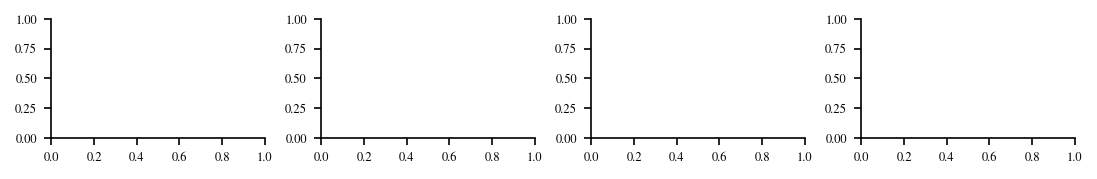

In [16]:
# Settings
ncols = len(keys)
cmap = 'gist_earth'
colors = plt.get_cmap(cmap)(np.linspace(0.0,0.9,len(rhos)))
set_font_sizes(conf='tight')
titles = ['Train Loss', 'Val Loss', 'Top-1 Acc.', 'Target Mass']

# Plotting
fig ,  axes = create_fig(ncols=ncols,size='double',h=0.15)

for i , (ax , key) in enumerate(zip(axes, keys)):
    for j , rho in enumerate(rhos):
        ax.plot(results['step']/1000, results[key][rho],lw=1.2,alpha=0.8,color=colors[j])
    ax.set_title(titles[i])
    ax.grid(ls='--',alpha=0.2,c='gray',lw=0.5)
    

# Create discrete colormap and colorbar with discrete colors
cmap = ListedColormap(colors)
bounds = np.arange(len(rhos) + 1)
norm = BoundaryNorm(bounds, cmap.N)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap,norm=norm),
    ax=ax, orientation='vertical',pad=0.05)

cbar.set_label(r'$\rho_{_{SAM}}$', rotation=0, labelpad=10)
# Ticks and labels
cbar.set_ticks(ticks=(np.arange(len(rhos)) + 0.5), labels= rhos)
cbar.ax.tick_params(length=0)  # Optional: remove tick lines for clarity
ax.set_xscale('log')
# ax.set_xlim(0,25)
axes[2].set_ylim(-0.05,1)
ax.set_xlim(left=1)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
fig.text(0.96, 0.01, r'Steps $[k]$', ha='center', va='center', fontsize=FONTSIZES['xs'])
params = make_params_dict([*fix_names,'alpha','cV','opt','gamma','p_error'])
# save_fig(fig, 'optimizer_long_training_linear_attn',params=params,date=True)
# 

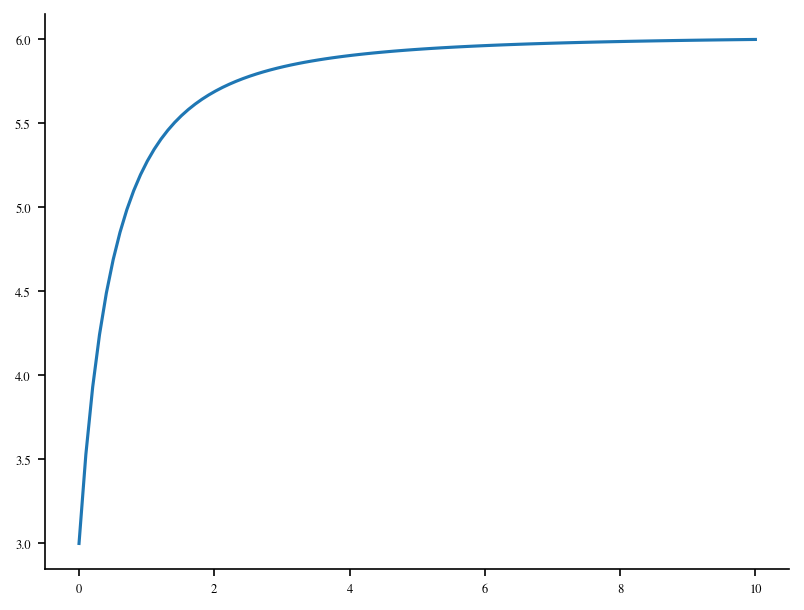

In [36]:
def fun_scale(rho_init,rho_final,t_tot,t,T0=1,gamma=1):
    
    aux = (1/T0)**gamma - (1/(t_tot+T0))**gamma
    B = (rho_final-rho_init)/aux
    A = rho_init - B*(1/T0)**gamma
    return A + B*(1/(t+T0))**gamma

    
rho_init = 3.0
rho_final = 0.0
t_tot = 10
t = np.linspace(0,t_tot,100)
f = fun_scale(rho_init,rho_final,t_tot,t,T0=1,gamma=2)

plt.plot(t,f)

In [22]:
from sam.small_models import InductionHeadAttention
from sam.dataset import get_sample_permut

In [23]:
# Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
lr = 0.05 # Learning rate
cV = 1.1 # Coefficient for WV1
alpha = 1.0
gamma = 0.0
opt = 'SAM' # Optimizer choice = 'SGD' or 'adam' or 'SAM'
alpha = 1.0
rho = 0.2
p_error = 0.30  
states = ['init','fin']

fix_names = ['vocab_size','seq_len','lr']
var_names = ['alpha','cV','opt','rho','gamma','p_error']
params = make_params_dict(fix_names, var_names)

model = InductionHeadAttention(vocab_size=vocab_size, seq_len=seq_len)
# /u/c/cerazova/SAM/data/small_induction_head/lr0.1_seq_len128_vocab_size128/model_fin_alpha0.1.pt
models = {}
for state in states:
    file_path , _, _ = make_data_paths(f'model_{state}', experiment_name= 'linear_attention', params=params,ext='pt',base_dir='../data')     
    models[state] = torch.load(file_path)

for key in models[state].keys():
    print(key, models[state][key].shape)

for state in states:
    text = ''
    for key in models[state].keys():
        if 'beta' in key:
            text += f'{key}: {models[state][key].cpu().numpy()}'
    print(f'{state}:\n{text}')

beta_1 torch.Size([])
beta_2 torch.Size([])
beta_out torch.Size([])
embedding.weight torch.Size([64, 64])
positions.weight torch.Size([64, 64])
WQ1.weight torch.Size([64, 64])
WK1.weight torch.Size([64, 64])
WV1.weight torch.Size([64, 64])
WQ2.weight torch.Size([64, 64])
WK2.weight torch.Size([64, 64])
init:
beta_1: 1.0beta_2: 1.0beta_out: 1.0
fin:
beta_1: 1.0beta_2: 1.0beta_out: 1.0


/tmp/ipykernel_3202769/2371730846.py:40: MatplotlibDeprecationWarning: Since Matplotlib 3.10 indicate_inset_[zoom] returns a single InsetIndicator artist with a rectangle property and a connectors property.  From 3.12 it will no longer be possible to unpack the return value into two elements.
  box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)


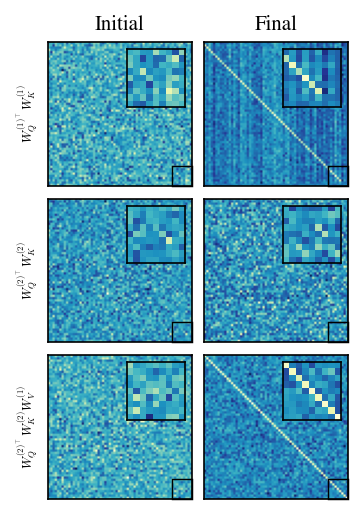

In [24]:
set_font_sizes(conf='tight')
cmap = 'YlGnBu'
titles = [r'$W_Q^{(1)^\top} W_K^{(1)}$',r'$W_Q^{(2)^\top} W_K^{(2)}$',r'$W_Q^{(2)^\top} W_K^{(2)} W_V^{(1)}$']
ncols = 2
nrows = 3
V = vocab_size
x = np.arange(V)
# Create figure
fig , axes = create_fig(ncols=ncols,nrows=nrows,size='double',w=0.32,h=0.46,sharex=False)

for i , state in enumerate(states):
    WQ1 = models[state]['WQ1.weight'].cpu().numpy()
    WK1 = models[state]['WK1.weight'].cpu().numpy()
    WQ2 = models[state]['WQ2.weight'].cpu().numpy()
    WK2 = models[state]['WK2.weight'].cpu().numpy()
    WV1 = models[state]['WV1.weight'].cpu().numpy()
    matrices = [WQ1.T@WK1, WQ2.T@WK2, WQ2.T@WK2@WV1]
    for j , lb in enumerate(titles):
        ax = axes[j,i]
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.spines[['bottom','left','top','right']].set_visible(True)
        if j == 0: ax.set_title([r'Initial', r'Final'][i])
        if i == 0: ax.set_ylabel(titles[j],fontsize=FONTSIZES['xs']) 
        M = matrices[j]
        mx = M.max()
        # ax.pcolormesh(x,x[::-1],M,cmap=cmap,vmax=mx*0.3,shading=None)
        im = ax.imshow(M,cmap=cmap,vmax=1.0*mx)
        # Insert axis to show closer look at the top-left corner
        if True:
            axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4])  # [x0, y0, width, height]
            axins.spines[['bottom','left','top','right']].set_visible(True)
            # axins.pcolormesh(x,x[::-1],M,cmap=cmap,vmax=mx*0.3)
            axins.imshow(M,cmap=cmap,vmax=1.0*mx)
            # axins.plot([0,V],[0,V],ls='--',c='red',lw=0.5)
            axins.set_xlim(V-9.5,V-0.5)
            axins.set_ylim(V-0.5,V-9.5)
            axins.set_xticks([])
            axins.set_yticks([])
            # ax.indicate_inset_zoom(axins, edgecolor='black', lw=0.5)
            box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)
            c1[0].set_visible(False)
            c1[1].set_visible(False)
            c1[2].set_visible(False)
            c1[3].set_visible(False)
            # ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)
            plt.setp([c1[:]], linestyle=":", lw=0.7)
            

# names = [*fix_names, '']
params = make_params_dict([*fix_names,'alpha','rho','opt','gamma','p_error'])
# save_fig(fig, 'optimizer_init_fin_matrices',params=params,date=True)


# Others

In [54]:
input, target, nsteps = get_sample_permut(V,L)
print("Input:", input)
print("Target:", target)

Input: tensor([98, 43, 78,  4, 28, 17, 42, 24, 19, 37, 94, 50, 92, 41, 18, 93, 22, 65,
        63, 46, 74, 84, 15, 55, 54, 58, 79, 72, 44, 73, 49, 88, 89, 29, 81,  8,
        52,  2, 99, 66, 27, 91, 26, 11, 34, 62, 51,  0, 67, 22])
Target: tensor(65)


<BarContainer object of 50 artists>

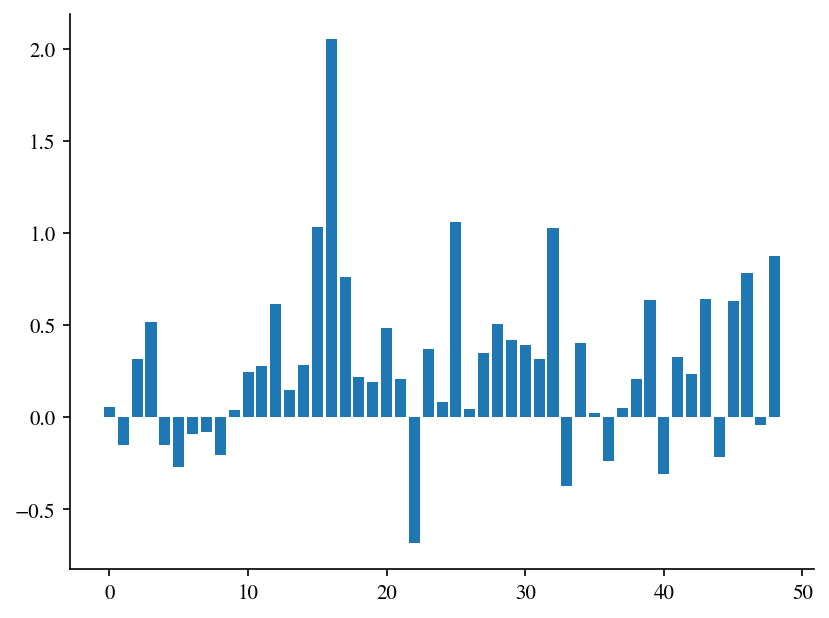

In [82]:
V = 100
L = int(V/2)
alpha=0.5

model = InductionHeadAttentionSmaller(vocab_size=V, seq_len=L)
planted_initialization_small(model,alpha,betas=(1.0,1.0,1.0),c=2)


output = model.full_output(input.unsqueeze(0))

for k,v in output.items():
    if k not in ['P','Q1','K1','S1']:
        output[k] = v[0]
    # print(f"{k}: {output[k].shape}")

var = output['S2'][0]
prob = torch.softmax(torch.tensor(var), dim=-1).numpy()
plt.bar(np.arange(len(var)), var)
# plt.axvline(x=target, color='red', linestyle='--',lw=0.5)
# plt.axvline(x=input[-1], color='green', linestyle='--',lw=0.5)
# plt.axvline(x=input[-2], color='blue', linestyle='--',lw=0.5)
# plt.yscale('log')

(450.0, 520.0)

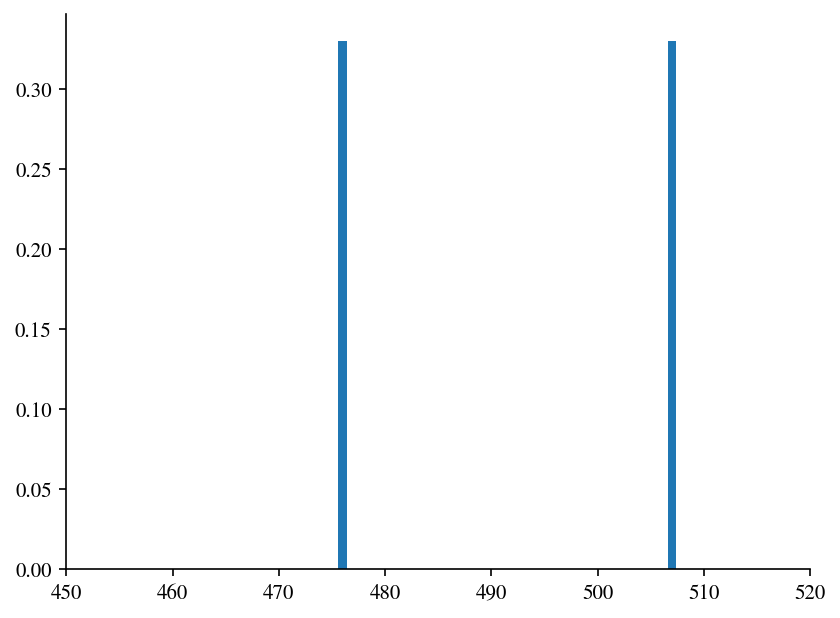

In [20]:
plt.bar(np.arange(len(var)), prob)

plt.xlim(450,520)

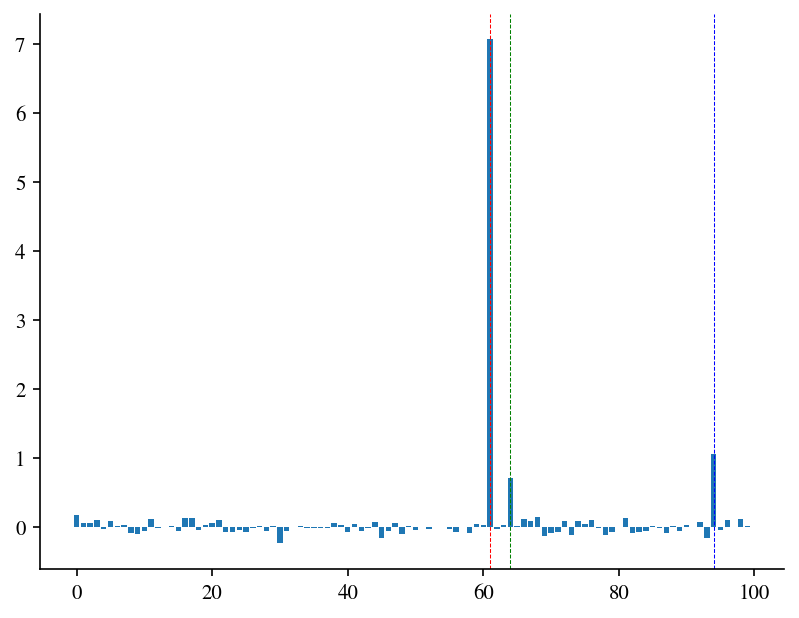

In [22]:
var = output['logits'][0]
plt.bar(np.arange(len(var)), var)
plt.axvline(x=target, color='red', linestyle='--',lw=0.5)
plt.axvline(x=input[-1], color='green', linestyle='--',lw=0.5)
plt.axvline(x=input[-2], color='blue', linestyle='--',lw=0.5)

In [17]:
var = output['Q2']
plt.imshow(var)
plt.colorbar()
# var[-1,-2]

KeyError: 'Q2'

<BarContainer object of 100 artists>

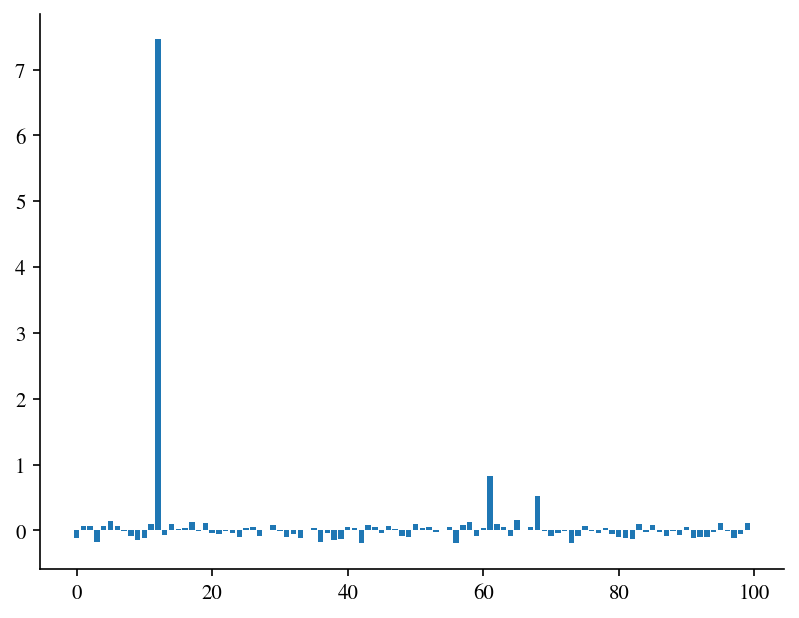

In [8]:
var = output['logits'][0]
plt.bar(np.arange(len(var)), var)

Input: tensor([14, 25, 18, 26,  1, 24, 12,  6, 19,  2, 11, 27, 15,  3, 12])
Target: tensor(6)


/u/c/cerazova/miniconda3/envs/sam/lib/python3.11/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


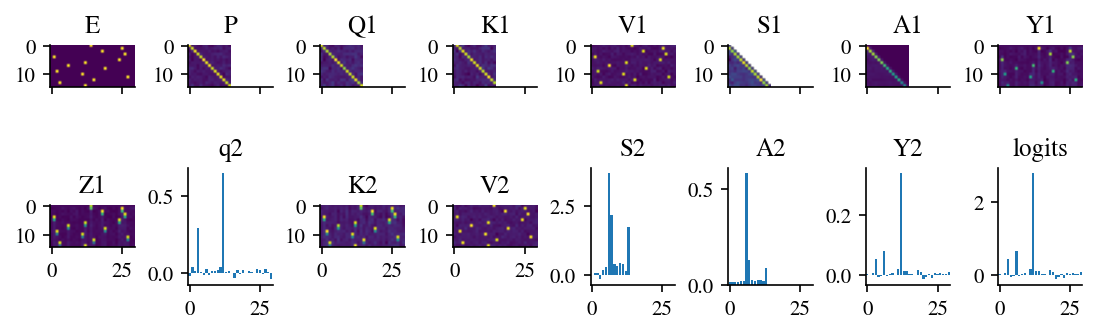

In [64]:
print("Input:", input)
print("Target:", target)
ncols = len(output.keys())//2
fig , axes = create_fig(ncols=ncols,nrows=2,size='double',h=0.3)
axes = axes.flatten()
for i, (k,v) in enumerate(output.items()):
    ax = axes[i]
    ax.set_title(k)
    if v.shape[0] == 1:
        ax.bar(range(v.shape[1]),v[0])
    else:
        ax.imshow(v, cmap='viridis')

/u/c/cerazova/miniconda3/envs/sam/lib/python3.11/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


<BarContainer object of 15 artists>

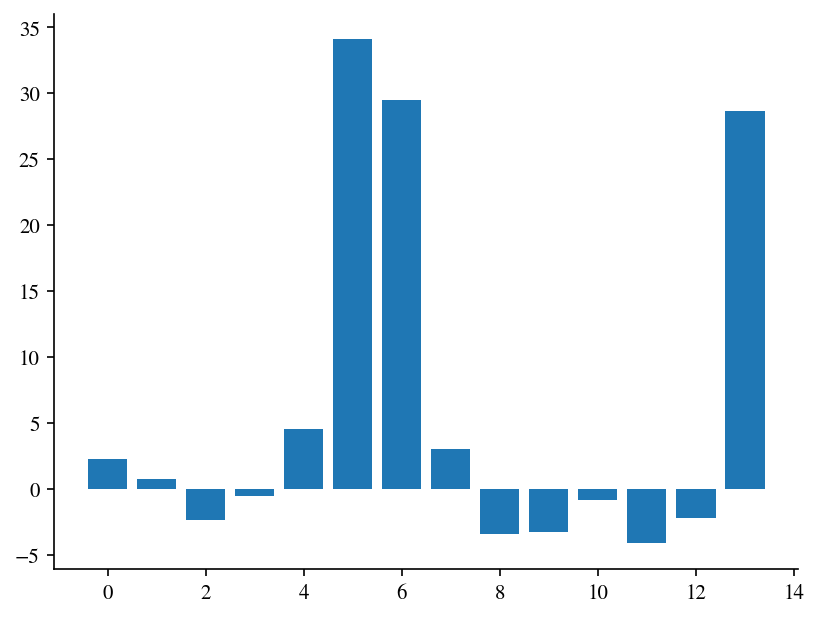